# Counterfactual Data Augmentation

The purpose of this notebook is to generate augmented gender-swapped bios using the original Bias in Bios train dataset.

The counterfactual dataset is generated using SpaCy for named entity recognition to identify pronouns and names. Pronouns were swapped via a pronoun-matching dictonary (i.e she:he) and names were replaced with the word 'PERSON' in an attempt to limit the model's capacity to pick up on gender cues through names.

Semantic similarity between the original and counterfactual bios was evaluated using cosine similarity from the sentence-transformers library.

*Table of Contents*

>[Setup](#scrollTo=rIQt40_H-mPh)

>[Anonymize names and swap pronouns](#scrollTo=1kTroDYK0v2p)

>[Apply to train data](#scrollTo=owxOsX_LBwHT)

>[Save to drive](#scrollTo=B9j_k2iU_ew1)

>[Semantic similarity](#scrollTo=qIV1b7SdB15Z)

## Setup



In [1]:
# Install dependencies
!pip install -q -U spacy datasets tqdm
!pip install -q -U sentence-transformers
!python -m spacy download en_core_web_sm

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 511.6/511.6 kB 35.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 47.7/47.7 MB 20.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.8/12.8 MB 149.4 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')
⚠ Restart to reload dependencies
If you are in a Jupyter or Colab notebook, you may need to restart Python in
order to load all the package's dependencies. You can do this by selecting the
'Restart kernel' or 'Restart runtime' option.


In [2]:
# Import libraries
import spacy
import pandas as pd
import matplotlib.pyplot as plt

import re
import torch

from sentence_transformers import SentenceTransformer, util
from datasets import Dataset, load_from_disk
from tqdm import tqdm

In [3]:
# Mount to Google Drive
from google.colab import drive
drive.mount('/content/drive')

path = '/content/drive/MyDrive/Colab-Notebooks/jordan-cda'

Mounted at /content/drive


In [ ]:
# Load original train dataset
train = load_from_disk(path + '/data_original/train')

In [ ]:
# Load SentenceTransformer for cosine similarities
model = SentenceTransformer("all-MiniLM-L6-v2")

modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md: 0.00B [00:00, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

## Anonymize names and swap pronouns

We started with simply having SpaCy's NER tool identify names in the bio and replace them with "PERSON" to anonymize names that are typically associated with males or females. However, we found that this logic overgeneralized to other names in the sentence, such as the titles of companies. To resolve this issue, we changed the logic to focus on using SpaCy's dependency parsing tool to identify the main subject in the sentence and replace only that name when it appears in the bio.

In [ ]:
# Initialize parser
nlp = spacy.load("en_core_web_sm")

In [ ]:
# Generate test samples
example_1 = "Mr. John Miller is a doctor. He loves his job and helps his patients."
example_2 = 'Mr. Schorr founded Schorr Law, A Professional Corporation in the winter of 2005 with the goal of providing a firm with expertise in a highly focused subject matter that caters to its clients’ specific needs.'
example_3 = 'Prior to law school, Brittni graduated magna cum laude from DePaul University in 2011 with her Bachelor’s Degree in Psychology and Spanish. In 2014, she earned her law degree from Chicago-Kent College of Law. While at Chicago-Kent, Brittni was awarded two CALI Excellence for the Future Awards in both Legal Writing and for her seminar article regarding President Obama’s executive action, Deferred Action for Childhood Arrivals.'
example_4 = 'She graduated with honors in 1979. Having more than 37 years of diverse experiences, especially in NURSE PRACTITIONER, Eileen J Odonnell affiliates with Lawrence & Memorial Hospital, and cooperates with other doctors and specialists in medical group Physicians For Women S Health LLC. Call Eileen J Odonnell on phone number (860) 444-6711 for more information and advises or to book an appointment.'

In [ ]:
# Map gendered opposites
GENDER_MAP = {
    # Pronouns
    "he": "she", "she": "he",
    "him": "her", "his": "her",
    "her": "him", "hers": "his",
    "himself": "herself", "herself": "himself",
    # Honorifics and roles
    "mr.": "ms.", "ms.": "mr.",
    "mister": "miss", "miss": "mister",
    "sir": "madame", "madame": "sir",
    # Gendered terms
    "man": "woman", "woman": "man",
    "men": "women", "women": "men",
    "male":"female", "female":"male",
    "boy":"girl", "girl":"boy",
    "guy":"gal", "gal":"guy",
}

In [ ]:
# Print example of dependency parser
doc = nlp(example_3)

for sent in doc.sents:
  print(f'Sentence: {sent.text}')
  for token in sent:
    print(f'Token: {token.text}, Dependency: {token.dep_}, Head: {token.head.text}')
  print('-'*20)

Sentence: Prior to law school, Brittni graduated magna cum laude from DePaul University in 2011 with her Bachelor’s Degree in Psychology and Spanish.
Token: Prior, Dependency: advmod, Head: graduated
Token: to, Dependency: prep, Head: Prior
Token: law, Dependency: compound, Head: school
Token: school, Dependency: pobj, Head: to
Token: ,, Dependency: punct, Head: graduated
Token: Brittni, Dependency: nsubj, Head: graduated
Token: graduated, Dependency: ROOT, Head: graduated
Token: magna, Dependency: compound, Head: cum
Token: cum, Dependency: compound, Head: laude
Token: laude, Dependency: dobj, Head: graduated
Token: from, Dependency: prep, Head: graduated
Token: DePaul, Dependency: compound, Head: University
Token: University, Dependency: pobj, Head: from
Token: in, Dependency: prep, Head: graduated
Token: 2011, Dependency: pobj, Head: in
Token: with, Dependency: prep, Head: graduated
Token: her, Dependency: poss, Head: Degree
Token: Bachelor, Dependency: nmod, Head: Degree
Token: ’s,

In [ ]:
# Use this function to check process and print samples
# DO NOT USE ON FULL DATASET
def generate_counterfactual_spacy_PRINTED(text):
    """
    Replace the name of the main person in the text with 'PERSON'.
    Swap pronouns/gendered terms (case-sensitive).
    """
    doc = nlp(text)
    print(f'doc: {doc}')

    swapped_text = list(doc.text)
    print(f'swapped text: {swapped_text}')

    #########
    # Anonymize main subject
    #########

    # Identify the noun subjects
    subjects = []

    for sent in doc.sents:
      for token in sent:
        if token.dep_ == 'nsubj':
          subjects.append(token.text) == token.text
          print(f'noun subjects: {subjects}')


    # Iterate in reverse to avoid index issues after replacement
    for ent in reversed(doc.ents):
        if ent.text in subjects:
            start, end = ent.start_char, ent.end_char
            print(f'start: {start}')
            print(f'end: {end}')
            swapped_text[start:end] = list("PERSON") # Replace entity span with 'PERSON'
            print(f'swapped text: {swapped_text}')
        else:
          pass

    # Reconstruct the text after entity replacement
    text_after_entity_swap = "".join(swapped_text)
    print(f'text after entity swap: {text_after_entity_swap}')

    doc_after_entity_swap = nlp(text_after_entity_swap) # Process the new text with spaCy again
    print(f'doc after entity swap: {doc_after_entity_swap}')

    swapped_tokens = []
    print(f'swapped tokens: {swapped_tokens}')

    ############
    # Pronoun and gendered word swaps (case-sensitive) on the text with PERSON placeholders
    ############
    for tok in doc_after_entity_swap:
        tok_text = tok.text
        lower_tok = tok_text.lower()
        print(f'tok text: {tok_text}')
        print(f'lower tok: {lower_tok}')

        if lower_tok in GENDER_MAP:
            swapped = GENDER_MAP[lower_tok]
            print(f'swapped: {swapped}')

            # Preserve capitalization
            if tok_text.istitle():
                swapped_tokens.append(swapped.capitalize())
            elif tok_text.isupper():
                swapped_tokens.append(swapped.upper())
            else:
                swapped_tokens.append(swapped)
        else:
            swapped_tokens.append(tok_text)
        print(f'swapped tokens: {swapped_tokens}')

    # Rebuild text with spaces
    final_text = " ".join(swapped_tokens)
    print(f'final text: {final_text}')

    # Remove whitespace before end of phrase tokens
    final_text = re.sub(r'\s+([.,;:\\!?])', r'\1', final_text)

    # Remove whitespace before and after forward slashes and apostrophes
    final_text = re.sub(r'\s*([/’])\s*', r'\1', final_text)

    print(f'final text: {final_text}')

    return final_text

#### Experiments with sample text and low-scoring training examples

In [ ]:
print("Original:", example_1)

cf_1 = generate_counterfactual_spacy_PRINTED(example_1)
cf_1

Original: Mr. John Miller is a doctor. He loves his job and helps his patients.
doc: Mr. John Miller is a doctor. He loves his job and helps his patients.
swapped text: ['M', 'r', '.', ' ', 'J', 'o', 'h', 'n', ' ', 'M', 'i', 'l', 'l', 'e', 'r', ' ', 'i', 's', ' ', 'a', ' ', 'd', 'o', 'c', 't', 'o', 'r', '.', ' ', 'H', 'e', ' ', 'l', 'o', 'v', 'e', 's', ' ', 'h', 'i', 's', ' ', 'j', 'o', 'b', ' ', 'a', 'n', 'd', ' ', 'h', 'e', 'l', 'p', 's', ' ', 'h', 'i', 's', ' ', 'p', 'a', 't', 'i', 'e', 'n', 't', 's', '.']
noun subjects: ['Miller']
noun subjects: ['Miller', 'He']
text after entity swap: Mr. John Miller is a doctor. He loves his job and helps his patients.
doc after entity swap: Mr. John Miller is a doctor. He loves his job and helps his patients.
swapped tokens: []
tok text: Mr.
lower tok: mr.
swapped: ms.
swapped tokens: ['Ms.']
tok text: John
lower tok: john
swapped tokens: ['Ms.', 'John']
tok text: Miller
lower tok: miller
swapped tokens: ['Ms.', 'John', 'Miller']
tok text: is
lo

'Ms. John Miller is a doctor. She loves her job and helps her patients.'

In [ ]:
print("Original:", example_2)

cf_2 = generate_counterfactual_spacy_PRINTED(example_2)
cf_2

Original: Mr. Schorr founded Schorr Law, A Professional Corporation in the winter of 2005 with the goal of providing a firm with expertise in a highly focused subject matter that caters to its clients’ specific needs.
doc: Mr. Schorr founded Schorr Law, A Professional Corporation in the winter of 2005 with the goal of providing a firm with expertise in a highly focused subject matter that caters to its clients’ specific needs.
swapped text: ['M', 'r', '.', ' ', 'S', 'c', 'h', 'o', 'r', 'r', ' ', 'f', 'o', 'u', 'n', 'd', 'e', 'd', ' ', 'S', 'c', 'h', 'o', 'r', 'r', ' ', 'L', 'a', 'w', ',', ' ', 'A', ' ', 'P', 'r', 'o', 'f', 'e', 's', 's', 'i', 'o', 'n', 'a', 'l', ' ', 'C', 'o', 'r', 'p', 'o', 'r', 'a', 't', 'i', 'o', 'n', ' ', 'i', 'n', ' ', 't', 'h', 'e', ' ', 'w', 'i', 'n', 't', 'e', 'r', ' ', 'o', 'f', ' ', '2', '0', '0', '5', ' ', 'w', 'i', 't', 'h', ' ', 't', 'h', 'e', ' ', 'g', 'o', 'a', 'l', ' ', 'o', 'f', ' ', 'p', 'r', 'o', 'v', 'i', 'd', 'i', 'n', 'g', ' ', 'a', ' ', 'f', 'i',

'Ms. PERSON founded Schorr Law, A Professional Corporation in the winter of 2005 with the goal of providing a firm with expertise in a highly focused subject matter that caters to its clients’specific needs.'

In [ ]:
print("Original:", example_3)

cf_3 = generate_counterfactual_spacy_PRINTED(example_3)
cf_3

Original: Prior to law school, Brittni graduated magna cum laude from DePaul University in 2011 with her Bachelor’s Degree in Psychology and Spanish. In 2014, she earned her law degree from Chicago-Kent College of Law. While at Chicago-Kent, Brittni was awarded two CALI Excellence for the Future Awards in both Legal Writing and for her seminar article regarding President Obama’s executive action, Deferred Action for Childhood Arrivals.
doc: Prior to law school, Brittni graduated magna cum laude from DePaul University in 2011 with her Bachelor’s Degree in Psychology and Spanish. In 2014, she earned her law degree from Chicago-Kent College of Law. While at Chicago-Kent, Brittni was awarded two CALI Excellence for the Future Awards in both Legal Writing and for her seminar article regarding President Obama’s executive action, Deferred Action for Childhood Arrivals.
swapped text: ['P', 'r', 'i', 'o', 'r', ' ', 't', 'o', ' ', 'l', 'a', 'w', ' ', 's', 'c', 'h', 'o', 'o', 'l', ',', ' ', 'B', 

'Prior to law school, PERSON graduated magna cum laude from DePaul University in 2011 with him Bachelor’s Degree in Psychology and Spanish. In 2014, he earned him law degree from Chicago - Kent College of Law. While at Chicago - Kent, PERSON was awarded two CALI Excellence for the Future Awards in both Legal Writing and for him seminar article regarding President Obama’s executive action, Deferred Action for Childhood Arrivals.'

In [ ]:
print("Original:", example_4)

cf_4 = generate_counterfactual_spacy_PRINTED(example_4)
cf_4

Original: She graduated with honors in 1979. Having more than 37 years of diverse experiences, especially in NURSE PRACTITIONER, Eileen J Odonnell affiliates with Lawrence & Memorial Hospital, and cooperates with other doctors and specialists in medical group Physicians For Women S Health LLC. Call Eileen J Odonnell on phone number (860) 444-6711 for more information and advises or to book an appointment.
doc: She graduated with honors in 1979. Having more than 37 years of diverse experiences, especially in NURSE PRACTITIONER, Eileen J Odonnell affiliates with Lawrence & Memorial Hospital, and cooperates with other doctors and specialists in medical group Physicians For Women S Health LLC. Call Eileen J Odonnell on phone number (860) 444-6711 for more information and advises or to book an appointment.
swapped text: ['S', 'h', 'e', ' ', 'g', 'r', 'a', 'd', 'u', 'a', 't', 'e', 'd', ' ', 'w', 'i', 't', 'h', ' ', 'h', 'o', 'n', 'o', 'r', 's', ' ', 'i', 'n', ' ', '1', '9', '7', '9', '.', ' 

'He graduated with honors in 1979. Having more than 37 years of diverse experiences, especially in NURSE PRACTITIONER, Eileen J Odonnell affiliates with Lawrence & Memorial Hospital, and cooperates with other doctors and specialists in medical group Physicians For Men S Health LLC. Call Eileen J Odonnell on phone number ( 860 ) 444 - 6711 for more information and advises or to book an appointment.'

#### Test cosine similarity for samples

In [ ]:
# Encode the original and counterfactual texts
emb_orig = model.encode(example_1, convert_to_tensor=True)
emb_cf = model.encode(cf_1, convert_to_tensor=True, )

# Calculate cosine similarity
score = util.cos_sim(emb_orig, emb_cf).cpu().numpy()

print(score)

[[0.9134637]]


### Apply to train data

The function above printed statements to provide an example for how the internals were functioning. The function below is the same as above, but without the print statements and should be used on the training dataset to generate the counterfactuals.

In [ ]:
# Identical to function above but without print commands
def generate_counterfactual_spacy(text):
    """
    Replace the name of the main person in the text with 'PERSON'.
    Swap pronouns/gendered terms (case-sensitive).
    """
    doc = nlp(text)

    swapped_text = list(doc.text)

    #########
    # Anonymize main subject
    #########

    # Identify the noun subjects
    subjects = []

    for sent in doc.sents:
      for token in sent:
        if token.dep_ == 'nsubj':
          subjects.append(token.text) == token.text


    # Iterate in reverse to avoid index issues after replacement
    for ent in reversed(doc.ents):
        if ent.text in subjects:
            start, end = ent.start_char, ent.end_char
            swapped_text[start:end] = list("PERSON") # Replace entity span with 'PERSON'
        else:
          pass

    # Reconstruct the text after entity replacement
    text_after_entity_swap = "".join(swapped_text)

    doc_after_entity_swap = nlp(text_after_entity_swap) # Process the new text with spaCy again

    swapped_tokens = []

    ############
    # Pronoun and gendered word swaps (case-sensitive) on the text with PERSON placeholders
    ############
    for tok in doc_after_entity_swap:
        tok_text = tok.text
        lower_tok = tok_text.lower()

        if lower_tok in GENDER_MAP:
            swapped = GENDER_MAP[lower_tok]

            # Preserve capitalization
            if tok_text.istitle():
                swapped_tokens.append(swapped.capitalize())
            elif tok_text.isupper():
                swapped_tokens.append(swapped.upper())
            else:
                swapped_tokens.append(swapped)
        else:
            swapped_tokens.append(tok_text)

    # Rebuild text with spaces
    final_text = " ".join(swapped_tokens)

    # Remove whitespace before end of phrase tokens
    final_text = re.sub(r'\s+([.,;:\\!?])', r'\1', final_text)

    # Remove whitespace before and after forward slashes and apostrophes
    final_text = re.sub(r'\s*([/’])\s*', r'\1', final_text)

    return final_text

In [ ]:
# Apply to datasets
train = train.map(lambda example: {"text_cf": generate_counterfactual_spacy(example["hard_text"])}, num_proc=4)

Map (num_proc=4):   0%|          | 0/257478 [00:00<?, ? examples/s]

In [ ]:
train[0]

{'hard_text': 'He is also the project lead of and major contributor to the open source assembler/simulator "EASy68K." He earned a master’s degree in computer science from the University of Michigan-Dearborn, where he is also an adjunct instructor. Downloads/Updates',
 'profession': 21,
 'gender': 0,
 'text_cf': 'She is also the project lead of and major contributor to the open source assembler/simulator " EASy68K. " She earned a master’s degree in computer science from the University of Michigan - Dearborn, where she is also an adjunct instructor. Downloads/Updates'}

In [ ]:
# Check by sampling
train.to_pandas()[["hard_text", "text_cf"]].sample(5, random_state=42)

,hard_text,text_cf
223763,"Ms. Crosby practices medicine in Augusta, GA a...","Mr. PERSON practices medicine in Augusta, GA a..."
122053,She graduated with honors in 2010. Having more...,He graduated with honors in 2010. Having more ...
137754,Her areas of expertise include adoption issues...,Him areas of expertise include adoption issues...
148916,She received her B.A. at Yale University and P...,He received him B.A. at Yale University and Ph...
63008,Her research interests focus on topics related...,Him research interests focus on topics related...


## Save to drive

In [ ]:
# Save cf data to drive
train.save_to_disk(path + '/data_counterfactual/train_cf')

Saving the dataset (0/1 shards):   0%|          | 0/257478 [00:00<?, ? examples/s]

In [4]:
# Run this cell to reload dataset
train = load_from_disk(path + '/data_counterfactual/train_cf')

In [5]:
# Confirm data load
print(train)

Dataset({
    features: ['hard_text', 'profession', 'gender', 'text_cf'],
    num_rows: 257478
})


**Note**

The wide dataframe above will be used to calculate semantic similarities for matched bios. The long dataset below will be tokenized in a subsequent notebook and used to train the CDA model.

In [10]:
# reverse gender label

train_cf_long = pd.melt(train.to_pandas(),
                        id_vars= ['profession', 'gender'],
                        value_vars= ['hard_text', 'text_cf'],
                        var_name= 'text_type',
                        value_name= 'text')

train_cf_long['cf_gender'] = train_cf_long.apply(
    lambda row: row['gender'] if row['text_type'] == 'hard_text' else 1 - row['gender'],
    axis = 1
)

train_cf_long.head(30)

,profession,gender,text_type,text,cf_gender
0,21,0,hard_text,He is also the project lead of and major contr...,0
1,13,1,hard_text,"She is able to assess, diagnose and treat mino...",1
2,2,1,hard_text,"Prior to law school, Brittni graduated magna c...",1
3,11,0,hard_text,He regularly contributes to India’s First Onli...,0
4,21,0,hard_text,He completed his medical degree at Northwester...,0
5,2,0,hard_text,Steve has practiced law in Kentucky for over 3...,0
6,21,0,hard_text,"His research is in information archiving, anal...",0
7,20,1,hard_text,"Trained as a doctor, she lives in Algiers wher...",1
8,25,0,hard_text,He graduated from University of Arkansas Colle...,0
9,11,0,hard_text,"Since February, 2010, he works at OWNI, a soci...",0


In [11]:
train_cf_long.tail(30)

,profession,gender,text_type,text,cf_gender
514926,21,1,text_cf,Harvey Leadership Institute at Hampton Univers...,0
514927,21,0,text_cf,"She has taught a variety of courses, including...",1
514928,2,1,text_cf,PERSON has represented injured clients in Texa...,0
514929,21,1,text_cf,He completed him PhD in physics at the Univers...,0
514930,5,0,text_cf,Her music has been played by The Royal Philhar...,1
514931,12,1,text_cf,In a world where men with beards are being loo...,0
514932,5,0,text_cf,"Inspired by Abū l-ʿAlāʾ al - Maʿarrī’s verse, ...",1
514933,19,1,text_cf,"With a goal of improving systems of care, he h...",0
514934,11,0,text_cf,Her fellowship story looks at youth activists ...,1
514935,25,0,text_cf,She was formerly at Division of Urological Sur...,1


In [12]:
# Drop original gender column and replace with updated genders
train_cf_long.drop('gender', axis= 1, inplace= True)
train_cf_long

,profession,text_type,text,cf_gender
0,21,hard_text,He is also the project lead of and major contr...,0
1,13,hard_text,"She is able to assess, diagnose and treat mino...",1
2,2,hard_text,"Prior to law school, Brittni graduated magna c...",1
3,11,hard_text,He regularly contributes to India’s First Onli...,0
4,21,hard_text,He completed his medical degree at Northwester...,0
...,...,...,...,...
514951,18,text_cf,"He photographs advertising images, people in b...",0
514952,24,text_cf,She is also a graduate of Communications and M...,1
514953,21,text_cf,He says PERSON of the first steps in stopping ...,0
514954,18,text_cf,She has been photographing for twenty years an...,1


In [16]:
# Rename new gender column
train_cf_long = train_cf_long.rename(columns= {'cf_gender':'gender'})
train_cf_long

,profession,text_type,text,gender
0,21,hard_text,He is also the project lead of and major contr...,0
1,13,hard_text,"She is able to assess, diagnose and treat mino...",1
2,2,hard_text,"Prior to law school, Brittni graduated magna c...",1
3,11,hard_text,He regularly contributes to India’s First Onli...,0
4,21,hard_text,He completed his medical degree at Northwester...,0
...,...,...,...,...
514951,18,text_cf,"He photographs advertising images, people in b...",0
514952,24,text_cf,She is also a graduate of Communications and M...,1
514953,21,text_cf,He says PERSON of the first steps in stopping ...,0
514954,18,text_cf,She has been photographing for twenty years an...,1


In [17]:
# Save long data to drive
dataset_cf_long = Dataset.from_pandas(train_cf_long)
dataset_cf_long.save_to_disk(path + '/data_counterfactual/train_cf_long')

Saving the dataset (0/1 shards):   0%|          | 0/514956 [00:00<?, ? examples/s]

## Semantic similarity

In [ ]:
# Encode the original and counterfactual texts
emb_orig = model.encode(train["hard_text"], convert_to_tensor=True, show_progress_bar=True)
emb_cf = model.encode(train["text_cf"], convert_to_tensor=True, show_progress_bar=True)

# Batch size for processing
batch_size = 1024

scores = []
# Process in batches
for i in tqdm(range(0, len(emb_orig), batch_size), desc="Calculating similarity"):
    batch_emb_orig = emb_orig[i:i + batch_size]
    batch_emb_cf = emb_cf[i:i + batch_size]

    # Calculate cosine similarity for the batch
    batch_scores = util.cos_sim(batch_emb_orig, batch_emb_cf).diagonal().cpu().numpy()
    scores.extend(batch_scores)

    # Clear GPU memory
    if torch.cuda.is_available():
        torch.cuda.empty_cache()


train_cf_sim = train.add_column("semantic_sim", scores)
display(train_cf_sim["semantic_sim"][:5])

Batches:   0%|          | 0/8047 [00:00<?, ?it/s]

Batches:   0%|          | 0/8047 [00:00<?, ?it/s]

Calculating similarity: 100%|██████████| 252/252 [00:00<00:00, 1163.00it/s]


[0.8885329961776733,
 0.8634209632873535,
 0.7925605773925781,
 0.9642499089241028,
 0.9643011093139648]

In [ ]:
# Save semantic sim dataset to drive
train_cf_sim.save_to_disk(path + '/data_counterfactual/train_cf_sim')

Saving the dataset (0/1 shards):   0%|          | 0/257478 [00:00<?, ? examples/s]

In [ ]:
# Reload semantic sim dataset
train_cf_sim = load_from_disk(path + '/data_counterfactual/train_cf_sim')

In [ ]:
# Convert to pandas df for easier manipulation
train_cf_df = train_cf_sim.to_pandas()
train_cf_df.head()

,hard_text,profession,gender,text_cf,semantic_sim
0,He is also the project lead of and major contr...,21,0,She is also the project lead of and major cont...,0.888533
1,"She is able to assess, diagnose and treat mino...",13,1,"He is able to assess, diagnose and treat minor...",0.863421
2,"Prior to law school, Brittni graduated magna c...",2,1,"Prior to law school, PERSON graduated magna cu...",0.792561
3,He regularly contributes to India’s First Onli...,11,0,She regularly contributes to India’s First Onl...,0.964250
4,He completed his medical degree at Northwester...,21,0,She completed her medical degree at Northweste...,0.964301


In [ ]:
# Check for samples with low semantic sim scores
train_cf_df[train_cf_df['semantic_sim'] < 0.50]

,hard_text,profession,gender,text_cf,semantic_sim
2016,He has extensive expertise in insurance covera...,2,0,She has extensive expertise in insurance cover...,0.491485
7332,Rick is a graduate of Western University with ...,26,0,PERSON is a graduate of Western University wit...,0.452122
7340,She joined the firm in August 2012. Ms. Elam i...,2,1,He joined the firm in August 2012. Mr. PERSON ...,0.452810
9595,"OCI is a consulting, development, and training...",24,0,"PERSON is a consulting, development, and train...",0.411372
14338,His work requires him to keep his distance and...,18,0,Her work requires her to keep her distance and...,0.480083
...,...,...,...,...,...
248862,REM follows its titular architect around the w...,9,0,PERSON follows its titular architect around th...,0.439384
250634,"Osgood is an award winning animator, illustrat...",21,0,"PERSON is an award winning animator, illustrat...",0.408806
254459,"Howie is standing up with the audience, he say...",4,0,"PERSON is standing up with the audience, she s...",0.443339
255213,Mr. Highsmith practices law as a named partner...,2,0,Ms. PERSON practices law as a named partner wi...,0.484369


In [ ]:
min_sim = min(train_cf_df['semantic_sim'])
min_sim

0.3379283547401428

In [ ]:
train_cf_df[train_cf_df['semantic_sim'] == min_sim]

,hard_text,profession,gender,text_cf,semantic_sim
192568,Wingspan is a Philadelphia-area software compa...,24,0,PERSON is a Philadelphia - area software compa...,0.337928


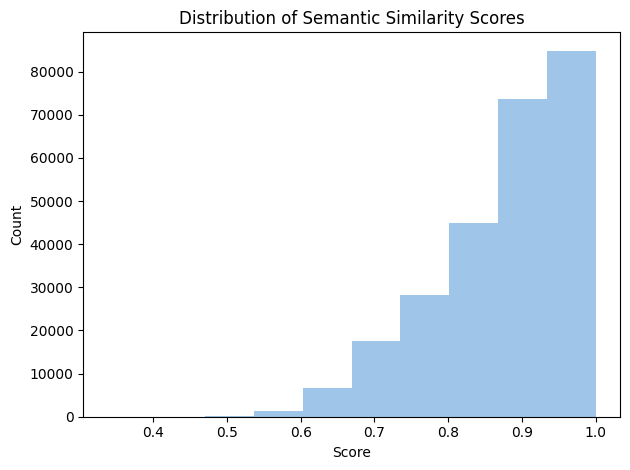

In [ ]:
plt.hist(train_cf_df['semantic_sim'], color = '#9fc5e8')
plt.title('Distribution of Semantic Similarity Scores')
plt.xlabel('Score')
plt.ylabel('Count')

plt.tight_layout()
plt.show()

In [ ]:
max_sim = max(train_cf_df['semantic_sim'])
max_sim

1.0000004768371582

In [ ]:
train_cf_df[train_cf_df['semantic_sim'] > 0.95]

,hard_text,profession,gender,text_cf,semantic_sim
3,He regularly contributes to India’s First Onli...,11,0,She regularly contributes to India’s First Onl...,0.964250
4,He completed his medical degree at Northwester...,21,0,She completed her medical degree at Northweste...,0.964301
7,"Trained as a doctor, she lives in Algiers wher...",20,1,"Trained as a doctor, he lives in Algiers where...",0.992844
10,When comparing Jim Giordano's ratings to other...,26,1,When comparing Jim Giordano 's ratings to othe...,1.000000
16,"In this capacity, Cara teaches courses in urba...",21,1,"In this capacity, PERSON teaches courses in ur...",0.990242
...,...,...,...,...,...
257460,He’s founded and led multiple congregations—so...,16,0,She’s founded and led multiple congregations —...,0.972577
257462,Archana Saraswat retired as a teacher in 2009 ...,26,1,Archana Saraswat retired as a teacher in 2009 ...,0.998521
257463,Inspired to become a midwife by her Peace Corp...,13,1,Inspired to become a midwife by him Peace Corp...,0.995688
257470,She earned a bachelor's degree in school psych...,26,1,He earned a bachelor 's degree in school psych...,0.973496
